title: Signup Introductory Page v2 – A/B Test in EU
author: Claudia Dai
date: 2021-01-08
region: EU
tags: acquire, ab test, signup, introductory page, conversion, cs contact
summary: A new introductory page design intends to provide users with more information on the account opening process experience. The goal of the new page design is to increase conversion and reduce CS contacts. The A/B test was launched mid October 2020. The flows in EU and US have different designs, thus, are set up separately from another. We will not analyze the US in this report. We analyze the time period from 20th October until 20th December 2020 for the EU experiment. We observe a 0.10pp increase with > 80% confidence for % SUI to KYCC within 7d. 0.45% (988 out of 217,936) exposed users in the treatment group clicked on the iframe. The lift translates into additional 375 users for monthly conversion, i.e. added monthly net contribution of 378.75 EUR. The page redesign contribution is minor, but also seems to have no negative impact on sign-up. For the hypothesis “the iframe provides useful information to improve signup conversion” it is recommended to set up a separate test.


# Signup Introductory Page v2 – A/B Test in EU

A new introductory page design intends to provide users with more information on the account opening process experience. The goal of the new page design is to increase conversion and reduce CS contacts.

The A/B test was launched mid October 2020. The flows in EU and US have different designs, thus, are set up separately from another. We will not analyze the US in this report. We analyze the time period from 20th October until 20th December 2020 for the EU experiment.

We observe a 0.10pp increase with > 80% confidence for % SUI to KYCC within 7d. 0.45% (988 out of 217,936) exposed users in the treatment group clicked on the iframe.

The lift translates into additional 375 users for monthly conversion, i.e. added monthly net contribution of 378.75 EUR. The page redesign contribution is minor, but also seems to have no negative impact on sign-up. For the hypothesis “the iframe provides useful information to improve signup conversion” it is recommended to set up a separate test.

**Slides can be found [here](https://docs.google.com/presentation/d/1MH6-_gdiAf8XVA-sGyYjHSdfxBp0eLGzOdYxWFAr3vw/edit#slide=id.gb0a5380750_0_409).**

This notebook queries and visualizes the data for the analysis.

In [1]:
%%capture
!pip install seaborn

In [2]:
import time
import warnings

warnings.filterwarnings("ignore")
from datetime import datetime
from os import path
from utils.datalib_database import df_from_sql

In [3]:
import pandas as pd

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 10)
import seaborn as sns

sns.set()

In [4]:
####################################################################
# Functions to get data from DWH


def timer(elapsed_time):
    return time.strftime("%H:%M:%S", time.gmtime(elapsed_time))


def generate_filename(folder, ticket_number, description, date_start, date_end):
    return "{}{}-extract-{}-{}-{}.csv".format(
        folder, ticket_number, description, date_start, date_end
    )


def query_data(query):
    return df_from_sql("redshiftreader", query)


def save_data(data, filename):
    data.to_csv(filename, index=False)


def get_data(query, filename):
    ts = time.time()
    data = query_data(query)
    te = time.time() - ts
    print("Finished querying data. Time elapsed: {}.".format(timer(te)))

    ts = time.time()
    save_data(data, filename)
    te = time.time() - ts
    print("Finished saving data. Time elapsed: {}.\n".format(timer(te)))


def check_file_exist(filename):
    return path.exists(filename)

In [5]:
date_start = "2020-10-20"
date_end = "2020-12-20"

---

# What's our sample size?

In [6]:
query = """
SELECT
    dbt.stg_upper_funnel.se_property,
    COUNT(DISTINCT COALESCE(dbt.stg_upper_funnel.shadow_user_id::text, dbt.stg_upper_funnel.domain_userid::text))::float AS user
FROM dbt.stg_upper_funnel 
LEFT JOIN dbt.zrh_lower_funnel 
    ON dbt.zrh_lower_funnel.user_created = dbt.stg_upper_funnel.user_created 
    AND datediff('days', dbt.zrh_lower_funnel.user_created::date, dbt.zrh_lower_funnel.created::date) <= 7
WHERE 1=1
    AND dbt.stg_upper_funnel.se_property IN ('introductory_page_v2_eu', 'introductory_page_v2_eu_control')
    AND dbt.stg_upper_funnel.created >= '{}'
    AND dbt.stg_upper_funnel.created <= '{}'
    AND coalesce(dbt.stg_upper_funnel.user_created, current_date) >= dbt.stg_upper_funnel.created 
    AND dbt.stg_upper_funnel.country != 'USA' 
    AND datediff('days', dbt.stg_upper_funnel.created::date, current_date) >= 7
GROUP BY 1
ORDER BY 1
""".format(
    date_start, date_end, date_start, date_end
)

In [7]:
filename = generate_filename("data/", "DATA-9307", "samplesize", date_start, date_end)
# get_data(query, filename)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 114, "funcName": "df_from_sql", "created": "20210107T125854", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "5ca6d301-84e5-41e0-ac48-81de3899471f", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 19.2249, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 124, "funcName": "df_from_sql", "created": "20210107T125914", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "5ca6d301-84e5-41e0-ac48-81de3899471f", "hostname": "172.18.0.4"}
Finished querying data. Time elapsed: 00:00:37.
Finished saving data. Tim

In [8]:
samplesize = pd.read_csv(filename)
samplesize.shape

(2, 2)

In [9]:
samplesize.head()

,se_property,user
0,introductory_page_v2_eu,217936.0
1,introductory_page_v2_eu_control,217529.0


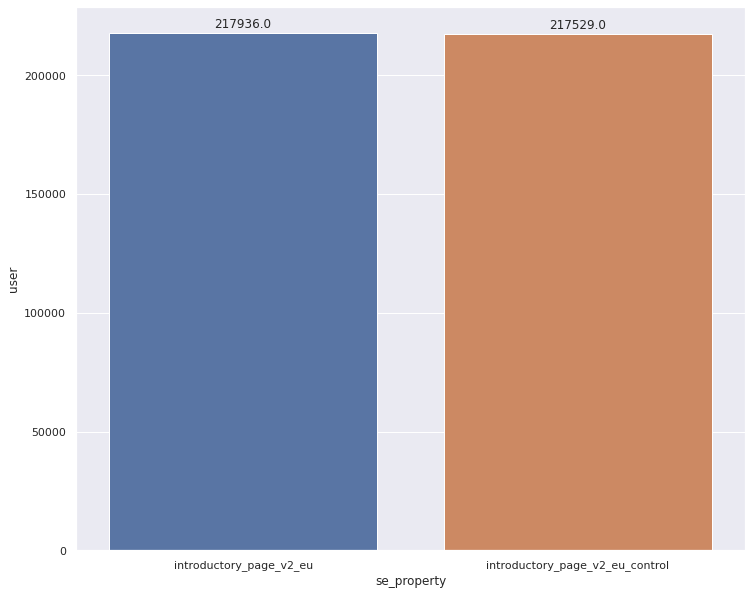

In [10]:
ax = sns.barplot(x="se_property", y="user", data=samplesize)
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".1f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )

---

# How many users clicked on the iframe?

In [11]:
query = """
DROP TABLE IF EXISTS clicks;

CREATE TEMP TABLE clicks AS
SELECT
    *
FROM dbt.snowplow
WHERE 1=1
    AND se_property = 'introductory_page_v2_eu'
    AND collector_tstamp >= '{}'
    AND collector_tstamp <= '{}';
    
SELECT
    CASE WHEN n_clicks > 0 THEN 'clicked' ELSE 'not_clicked' END AS flag,
    COUNT(user)
FROM (
    SELECT
        coalesce(dbt.stg_upper_funnel.shadow_user_id::text, dbt.stg_upper_funnel.domain_userid::text) AS user,
        COUNT(DISTINCT CASE WHEN clicks.se_action = 'registration.introduction_info_dialog_open' THEN clicks.event_id END) AS n_clicks
    FROM dbt.stg_upper_funnel 
    LEFT JOIN dbt.zrh_lower_funnel 
        ON dbt.zrh_lower_funnel.user_created = dbt.stg_upper_funnel.user_created 
        AND datediff('days', dbt.zrh_lower_funnel.user_created::date, dbt.zrh_lower_funnel.created::date) <= 7
    LEFT JOIN clicks
        ON dbt.stg_upper_funnel.user_created = clicks.user_created
        AND dbt.stg_upper_funnel.shadow_user_id = clicks.shadow_user_id
        AND dbt.stg_upper_funnel.domain_userid = clicks.domain_userid
    WHERE 1=1
        AND dbt.stg_upper_funnel.se_property = 'introductory_page_v2_eu'
        AND dbt.stg_upper_funnel.created >= '{}'
        AND dbt.stg_upper_funnel.created <= '{}'
        AND coalesce(dbt.stg_upper_funnel.user_created, current_date) >= dbt.stg_upper_funnel.created 
        AND dbt.stg_upper_funnel.country != 'USA' 
        AND datediff('days', dbt.stg_upper_funnel.created::date, current_date) >= 7
    GROUP BY 1
)
GROUP BY 1
ORDER BY 1
""".format(
    date_start, date_end, date_start, date_end
)

In [12]:
filename = generate_filename("data/", "DATA-9307", "nclicks", date_start, date_end)
# get_data(query, filename)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 114, "funcName": "df_from_sql", "created": "20210107T125919", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "5ca6d301-84e5-41e0-ac48-81de3899471f", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 135.6101, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 124, "funcName": "df_from_sql", "created": "20210107T130135", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "5ca6d301-84e5-41e0-ac48-81de3899471f", "hostname": "172.18.0.4"}
Finished querying data. Time elapsed: 00:02:28.
Finished saving data. Ti

In [13]:
nclicks = pd.read_csv(filename)
nclicks.shape

(2, 2)

In [14]:
nclicks.head()

,flag,count
0,clicked,988
1,not_clicked,216949


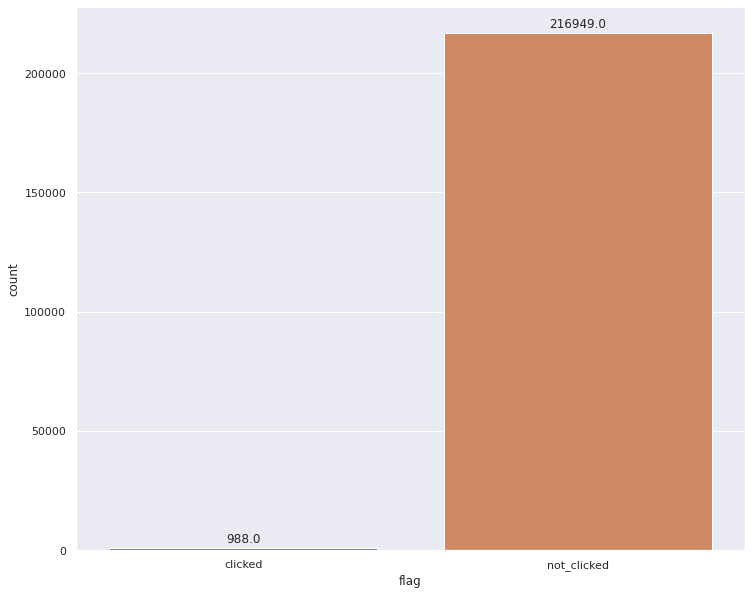

In [15]:
ax = sns.barplot(x="flag", y="count", data=nclicks)
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".1f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )

---

# What is the click distribution for users?

In [16]:
query = """
DROP TABLE IF EXISTS clicks;

CREATE TEMP TABLE clicks AS
SELECT
    *
FROM dbt.snowplow
WHERE 1=1
    AND se_property = 'introductory_page_v2_eu'
    AND collector_tstamp >= '{}'
    AND collector_tstamp <= '{}';
    
SELECT
    n_clicks,
    COUNT(user)
FROM (
    SELECT
        coalesce(dbt.stg_upper_funnel.shadow_user_id::text, dbt.stg_upper_funnel.domain_userid::text) AS user,
        COUNT(DISTINCT CASE WHEN clicks.se_action = 'registration.introduction_info_dialog_open' THEN clicks.event_id END) AS n_clicks
    FROM dbt.stg_upper_funnel 
    LEFT JOIN dbt.zrh_lower_funnel 
        ON dbt.zrh_lower_funnel.user_created = dbt.stg_upper_funnel.user_created 
        AND datediff('days', dbt.zrh_lower_funnel.user_created::date, dbt.zrh_lower_funnel.created::date) <= 7
    LEFT JOIN clicks
        ON dbt.stg_upper_funnel.user_created = clicks.user_created
        AND dbt.stg_upper_funnel.shadow_user_id = clicks.shadow_user_id
        AND dbt.stg_upper_funnel.domain_userid = clicks.domain_userid
    WHERE 1=1
        AND dbt.stg_upper_funnel.se_property = 'introductory_page_v2_eu'
        AND dbt.stg_upper_funnel.created >= '{}'
        AND dbt.stg_upper_funnel.created <= '{}'
        AND coalesce(dbt.stg_upper_funnel.user_created, current_date) >= dbt.stg_upper_funnel.created 
        AND dbt.stg_upper_funnel.country != 'USA' 
        AND datediff('days', dbt.stg_upper_funnel.created::date, current_date) >= 7
    GROUP BY 1
    HAVING n_clicks > 0
)
GROUP BY 1
ORDER BY 1
""".format(
    date_start, date_end, date_start, date_end
)

In [17]:
filename = generate_filename("data/", "DATA-9307", "dclicks", date_start, date_end)
# get_data(query, filename)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 114, "funcName": "df_from_sql", "created": "20210107T130152", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "5ca6d301-84e5-41e0-ac48-81de3899471f", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 190.9414, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 124, "funcName": "df_from_sql", "created": "20210107T130503", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "5ca6d301-84e5-41e0-ac48-81de3899471f", "hostname": "172.18.0.4"}
Finished querying data. Time elapsed: 00:04:00.
Finished saving data. Ti

In [18]:
dclicks = pd.read_csv(filename)
dclicks.shape

(7, 2)

In [19]:
dclicks

,n_clicks,count
0,1,899
1,2,70
2,3,10
3,4,4
4,5,3
5,7,1
6,8,1


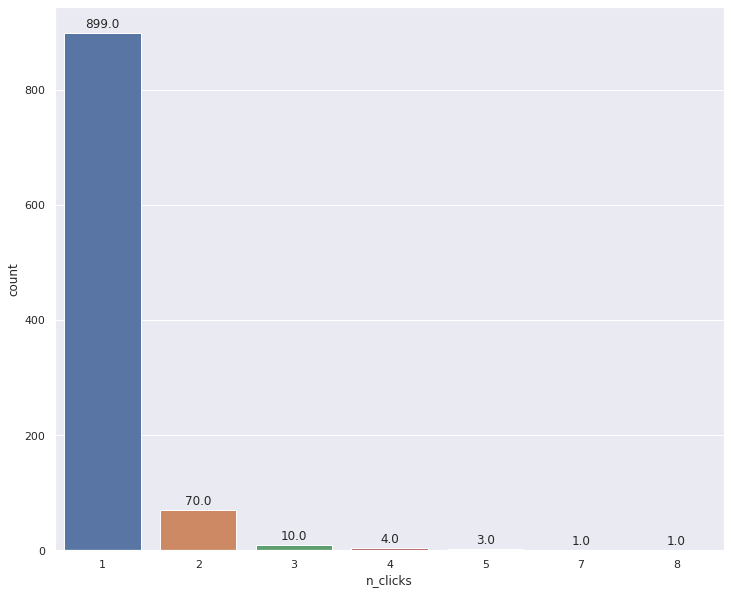

In [20]:
ax = sns.barplot(x="n_clicks", y="count", data=dclicks)
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".1f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )

In [21]:
dclicks

,n_clicks,count
0,1,899
1,2,70
2,3,10
3,4,4
4,5,3
5,7,1
6,8,1


In [22]:
dclicks["count"].sum()

988

---

# What about CS contact points?

[CS Tagging System](https://number26-jira.atlassian.net/wiki/spaces/CSKB/pages/1169227779/Tagging+System+2.0)

In [23]:
query = """  
DROP TABLE IF EXISTS clicks;

CREATE TEMP TABLE clicks AS
SELECT
    *
FROM dbt.snowplow
WHERE 1=1
    AND se_property = 'introductory_page_v2_eu'
    AND collector_tstamp >= '{}'
    AND collector_tstamp <= '{}';
    
CREATE TEMP TABLE cs AS
SELECT
    dbt.sf_all_contacts.id,
    dbt.sf_all_contacts.user_id,
    dbt.zrh_users.user_created,
    dbt.sf_all_contacts.initiated_date,
    dbt.sf_all_contacts.case_tag,
    dbt.sf_all_contacts.cs_tag
FROM dbt.sf_all_contacts
INNER JOIN dbt.zrh_users
ON dbt.sf_all_contacts.user_id = dbt.zrh_users.user_id
WHERE 1=1
    AND dbt.sf_all_contacts.initiated_date >= '2020-10-20'
    AND dbt.sf_all_contacts.initiated_date <= '2020-12-20'
    AND dbt.sf_all_contacts.cs_tag IN (
        'sign_up',
        'kyc_issue',
        'kyc_acceptance'
    );
    
SELECT
    CASE WHEN n_clicks > 0 THEN 'clicked' ELSE 'not_clicked' END AS flag,
    COUNT(CASE WHEN n_cs > 0 THEN user END) AS cs_contacted,
    COUNT(CASE WHEN n_cs = 0 THEN user END) AS no_cs
FROM (
    SELECT
        coalesce(dbt.stg_upper_funnel.shadow_user_id::text, dbt.stg_upper_funnel.domain_userid::text) AS user,
        COUNT(DISTINCT CASE WHEN clicks.se_action = 'registration.introduction_info_dialog_open' THEN clicks.event_id END) AS n_clicks,
        COUNT(cs.id) AS n_cs
    FROM dbt.stg_upper_funnel 
    LEFT JOIN dbt.zrh_lower_funnel 
        ON dbt.zrh_lower_funnel.user_created = dbt.stg_upper_funnel.user_created 
        AND datediff('days', dbt.zrh_lower_funnel.user_created::date, dbt.zrh_lower_funnel.created::date) <= 7
    LEFT JOIN clicks
        ON dbt.stg_upper_funnel.user_created = clicks.user_created
        AND dbt.stg_upper_funnel.shadow_user_id = clicks.shadow_user_id
        AND dbt.stg_upper_funnel.domain_userid = clicks.domain_userid
    LEFT JOIN cs
        ON cs.user_created = dbt.stg_upper_funnel.user_created
    WHERE 1=1
        AND dbt.stg_upper_funnel.se_property = 'introductory_page_v2_eu'
        AND dbt.stg_upper_funnel.created >= '{}'
        AND dbt.stg_upper_funnel.created <= '{}'
        AND coalesce(dbt.stg_upper_funnel.user_created, current_date) >= dbt.stg_upper_funnel.created 
        AND dbt.stg_upper_funnel.country != 'USA' 
        AND datediff('days', dbt.stg_upper_funnel.created::date, current_date) >= 7
    GROUP BY 1
)
GROUP BY 1
ORDER BY 1
""".format(
    date_start, date_end, date_start, date_end, date_start, date_end
)

In [24]:
filename = generate_filename("data/", "DATA-9307", "cs", date_start, date_end)
# get_data(query, filename)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 114, "funcName": "df_from_sql", "created": "20210107T130555", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "5ca6d301-84e5-41e0-ac48-81de3899471f", "hostname": "172.18.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 171.9347, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 124, "funcName": "df_from_sql", "created": "20210107T130847", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "5ca6d301-84e5-41e0-ac48-81de3899471f", "hostname": "172.18.0.4"}
Finished querying data. Time elapsed: 00:03:05.
Finished saving data. Ti

In [25]:
cs = pd.read_csv(filename)
cs.shape

(2, 3)

In [26]:
cs.head()

,flag,cs_contacted,no_cs
0,clicked,67,921
1,not_clicked,3140,213809


In [27]:
cs = cs.set_index("flag").unstack().reset_index(name="value")
cs.rename(columns={"level_0": "feat"}, inplace=True)

In [28]:
cs

,feat,flag,value
0,cs_contacted,clicked,67
1,cs_contacted,not_clicked,3140
2,no_cs,clicked,921
3,no_cs,not_clicked,213809


In [71]:
988 / 217936

0.004533441010204831

In [49]:
clicked_yes = cs[cs["flag"] == "clicked"]
clicked_no = cs[cs["flag"] == "not_clicked"]

In [68]:
100 * clicked_yes[clicked_yes["feat"] == "cs_contacted"].value.iloc[0] / (
    clicked_yes[clicked_yes["feat"] == "cs_contacted"].value.iloc[0]
    + clicked_yes[clicked_yes["feat"] == "no_cs"].value.iloc[0]
)

6.781376518218623

In [69]:
100 * clicked_no[clicked_no["feat"] == "cs_contacted"].value.iloc[0] / (
    clicked_no[clicked_no["feat"] == "cs_contacted"].value.iloc[0]
    + clicked_no[clicked_no["feat"] == "no_cs"].value.iloc[0]
)

1.4473447676642897

In [70]:
3140 + 213809

216949

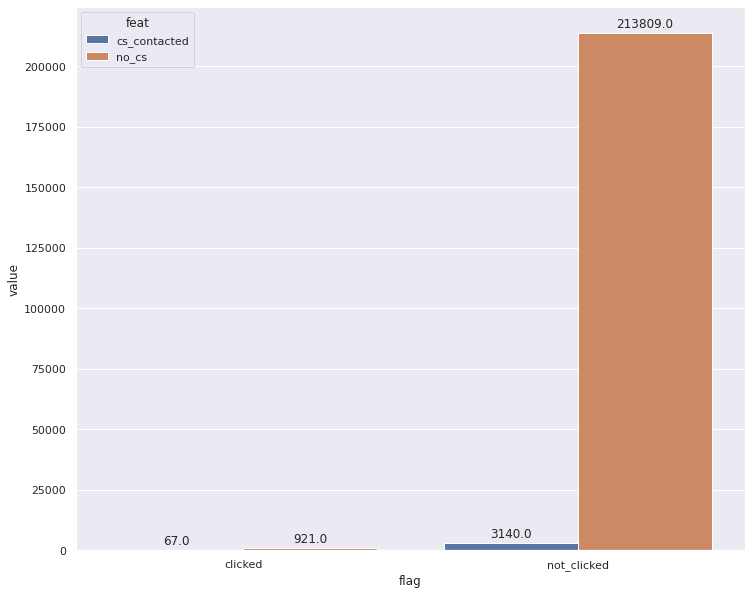

In [32]:
ax = sns.barplot(x="flag", y="value", hue="feat", data=cs)
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".1f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )